In [6]:
import sys
import os
import pandas as pd
import gzip
import numpy as np
import jax
import jax.numpy as jnp
import time
import pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

## Covtype: https://archive.ics.uci.edu/ml/datasets/covertype

In [2]:
covtype_path = "data/covtype.data.gz"

covtype_np = np.loadtxt(covtype_path, delimiter=',')
print(covtype_np.shape)

(581012, 55)


In [3]:
covtype_feature = covtype_np[:,:-1]
covtype_label = covtype_np[:,-1].reshape(-1,1).astype(int)
covtype_label = covtype_label - 1

print(covtype_feature.shape)
print(covtype_label.shape)

(581012, 54)
(581012, 1)


In [4]:
print(pd.DataFrame(np.unique(covtype_label, return_counts=True)).T)

   0       1
0  0  211840
1  1  283301
2  2   35754
3  3    2747
4  4    9493
5  5   17367
6  6   20510


In [51]:
covtype_feature_train, covtype_feature_test, covtype_label_train, covtype_label_test = \
    train_test_split(covtype_feature, covtype_label, random_state=4212)

In [52]:
print(covtype_feature_train.shape)
print(covtype_label_train.shape)
print(covtype_feature_test.shape)
print(covtype_label_test.shape)

(435759, 54)
(435759, 1)
(145253, 54)
(145253, 1)


In [5]:
covtype_df = pd.DataFrame(covtype_feature)

covtype_df.iloc[:,:10].describe()

,0,1,2,3,4,5,6,7,8,9
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


In [47]:
num_attribs = np.arange(0,10,1)
cat_attribs = np.arange(10,54,1)

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),
    ],remainder='passthrough')

covtype_feature_train_norm = full_pipeline.fit_transform(covtype_feature_train)
covtype_feature_test_norm = full_pipeline.transform(covtype_feature_test)
print(covtype_feature_train_norm.shape)
print(covtype_feature_test_norm.shape)

(435759, 54)
(145253, 54)


## MNIST: http://yann.lecun.com/exdb/mnist/

In [119]:
def training_images():
    with gzip.open('data/train-images-idx3-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images


def training_labels():
    with gzip.open('data/train-labels-idx1-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels.reshape(-1,1)
    
def test_images():
    with gzip.open('data/t10k-images-idx3-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images


def test_labels():
    with gzip.open('data/t10k-labels-idx1-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels.reshape(-1,1)

In [120]:
mnist_train_images = training_images()
mnist_train_labels = training_labels()
print(mnist_train_images.shape)
print(mnist_train_labels.shape)

(60000, 28, 28)
(60000, 1)


In [121]:
mnist_test_images = test_images()
mnist_test_labels = test_labels()
print(mnist_test_images.shape)
print(mnist_test_labels.shape)

(10000, 28, 28)
(10000, 1)


In [122]:
print(pd.DataFrame(np.unique(mnist_train_labels, return_counts=True)).T)

   0     1
0  0  5923
1  1  6742
2  2  5958
3  3  6131
4  4  5842
5  5  5421
6  6  5918
7  7  6265
8  8  5851
9  9  5949


## Adult: https://archive.ics.uci.edu/ml/datasets/adult

In [25]:
## Need further data cleaning & manipulating

adult_train = "data/adult.data"
adult_test = "data/adult.test"
adult_train_df = pd.read_csv(adult_train, header=None)
adult_test_df = pd.read_csv(adult_test, index_col=None)
adult_test_df = adult_test_df.reset_index()

In [26]:
adult_col_names = ['age','workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation','relationship','race','sex','capital-gain','capital-loss', 'hours-per-week','native-country', 'salary']
adult_train_df.columns = adult_col_names
adult_test_df.columns = adult_col_names

In [39]:
adult_feature_train = adult_train_df.iloc[:,:-1] 
adult_label_train = adult_train_df.iloc[:,-1]
adult_feature_test = adult_test_df.iloc[:,:-1]
adult_label_test = adult_test_df.iloc[:,-1]

In [40]:
print(adult_feature_train.shape)
print(adult_label_train.shape)
print(adult_feature_test.shape)
print(adult_label_test.shape)

(32561, 14)
(32561,)
(16281, 14)
(16281,)


In [41]:
adult_feature_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [184]:
print(pd.DataFrame(np.unique(adult_label_train, return_counts=True)).T)
print(pd.DataFrame(np.unique(adult_label_test, return_counts=True)).T)

        0      1
0   <=50K  24720
1    >50K   7841
         0      1
0   <=50K.  12435
1    >50K.   3846


In [43]:
adult_feature_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


### Work in progress: One-hot encoding cat variables
### Work in progress: Normalize 

In [44]:
num_attribs = adult_feature_train.columns[adult_train_feature.dtypes == 'int64']
cat_attribs = adult_feature_train.columns[adult_train_feature.dtypes == 'object']
print(num_attribs)
print(cat_attribs)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')
Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')


In [197]:
num_attribs = adult_feature_train.columns[adult_train_feature.dtypes == 'int64']
cat_attribs = adult_feature_train.columns[adult_train_feature.dtypes == 'object']

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),
        ("cat", OneHotEncoder(), cat_attribs)
    ])

adult_feature_train_norm = full_pipeline.fit_transform(adult_feature_train)
adult_feature_train_norm = adult_feature_train_norm.toarray()
adult_feature_test_norm = full_pipeline.transform(adult_feature_test)
adult_feature_test_norm = adult_feature_test_norm.toarray()

print(adult_feature_train_norm.shape)
print(adult_feature_test_norm.shape)

(32561, 108)
(16281, 108)


In [203]:
n_train = adult_label_train.shape[0]
n_test = adult_label_test.shape[0]
adult_label_train_bi = np.zeros(n_train)
adult_label_test_bi = np.zeros(n_test)

adult_label_train_bi[adult_label_train == adult_label_train.unique()[1]] = 1
adult_label_test_bi[adult_label_test == adult_label_test.unique()[1]] = 1
adult_label_train_bi = adult_label_train_bi.astype(int)
adult_label_test_bi = adult_label_test_bi.astype(int)
print(pd.DataFrame(np.unique(adult_label_train_bi, return_counts=True)).T)
print(pd.DataFrame(np.unique(adult_label_test_bi, return_counts=True)).T)

   0      1
0  0  24720
1  1   7841
   0      1
0  0  12435
1  1   3846


# Utility Functions

## Common Utility

In [56]:
@jax.jit
def pred_proba(beta, x):
    """ predict the probability vector of x belonging to each class """
    scores = beta@x
    return jnp.exp(scores) / jnp.sum(jnp.exp(scores))

pred_proba_batch = jax.vmap(pred_proba, in_axes=(None, 0)) # Vectorize Predict Function

In [57]:
@jax.jit
def get_label(p):
    pred_label = jnp.argmax(p)
    return pred_label

def get_label_batch(P):
    labels = jax.vmap(get_label,in_axes=[0])(P)
    return labels.reshape(-1,1)
# get_label_batch = jax.vmap(get_label,in_axes=[0])

def get_accuracy(pred_labels, Y):
    """ Compare the predicted probability (p) with the ground truth labels (Y) to get the accuracy """
    return jnp.mean(Y==pred_labels)

def test_acc(beta,test_label, test_data):
    # Memory Problem
    N = test_label.shape[0]
    bs = 100
    
    running_acc=0
    n_mb=0
    
    for i in range(0,N,bs):
        mb_data = test_data[i:i+bs]
        mb_label = test_label[i:i+bs]
        
        mb_pred = pred_proba_batch(beta, mb_data)
        mb_pred_labels = get_label_batch(mb_pred)
        mb_acc = get_accuracy(mb_pred_labels, mb_label)
        
        running_acc += mb_acc
        n_mb += 1
    
    # test_acc = jnp.dot(running_acc, batch_sizes) / jnp.sum(batch_sizes)
    test_acc = running_acc / n_mb
        
    # test_pred = pred_proba_batch(beta, test_data)
    # test_acc = get_accuracy(test_pred, Y_true)
    return test_acc

## Graph Plotting

In [212]:
def record_graph(record_list, key='test_acc_epoch', title="Summary of Results", alpha=0.6, n = None):
    """
    Plot graph of records in the list
    
    Args:
     record_list: List of record (dictionary) as returned by model training functions
     key: Performance metric to be plotted
     n: Number of results to be plotted, full results will be plotted if None
     
    Output:
     Multiple lines of the record on the same graph
    """
    keys = record_list[0].keys()
    if key not in keys:
        print(f'{key} is an invalid key!')
        print(f'Please enter one of the following: {keys}')
        
    plt.figure(figsize=(16,10))
        
    for record in record_list:
        if n == None:
            n = len(record.get(key))
        y = record.get(key)[:n]
        x = np.arange(n)

        if 'var' in key:
            labels = ["grad_" + str(i) for i in range(y[0].shape[0])]
        else:
            labels = record.get('name')
        plt.plot(x,
                 y, 
                 "-.",
                 alpha=alpha,
                 label=labels)
        if 'epoch' in key:
            plt.xticks(range(n))
    
    plt.legend()
    plt.xlabel(f'{key}'.split('_')[-1])
    plt.ylabel(' '.join(f'{key}'.split('_')[:-1]))
    plt.grid(True)
    plt.title(title)

## Multi-Class Logistic Regression

In [59]:
# Multi-Class Logistic Regression Loss
@jax.jit
def loss_single(beta, x, y):
    """
     Loss of a single data in multi-class Logistic Regression
    input:
     beta: Model parameters of shape [n, p], n = number of classes for label, p = dimension of features
     x: feature variables of shape p
     y: label, a single number indicating which class the data belongs to 
    """
    scores = beta@x
    scores = jnp.exp(scores) / jnp.sum(jnp.exp(scores)) # Softmax
    
    # scores = jax.nn.softmax(scores) # Softmax
    loss = -jnp.log(scores[y]) # Negative Loglikelihood of True Class
    return loss
    
loss_batch = jax.vmap(loss_single,in_axes=[None, 0, 0]) # Vectorize

def loss_LR(beta, X, Y):
    return jnp.mean(loss_batch(beta, X, Y))

In [60]:
# compute derivates
loss_LR_grad = jax.jit(jax.grad(loss_LR, argnums=0))
loss_LR_values_and_grad = jax.jit(jax.value_and_grad(loss_LR, argnums=0))

### Testing Grad Var Calculation

In [78]:
sum_grad_norm = jnp.zeros(7)
sum_grad_norm_2 = jnp.zeros(7)

In [79]:
print(sum_grad_norm_2)
print(sum_grad_norm)

[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


In [80]:
_, grad1 = loss_LR_values_and_grad(beta_init, covtype_feature_train_norm[:1000], covtype_label_train[:1000])
_, grad2 = loss_LR_values_and_grad(beta_init, covtype_feature_train_norm[1000:2000], covtype_label_train[1000:2000])
print(grad1.shape)
print(grad2.shape)

(7, 54)
(7, 54)


In [81]:
new_grad_norm = jnp.linalg.norm(grad1,axis=1)
sum_grad_norm_2 += new_grad_norm**2
sum_grad_norm += new_grad_norm
print(new_grad_norm)
print(sum_grad_norm_2)
print(sum_grad_norm)

[0.2910855  0.33604226 0.20581408 0.12155367 0.12237841 0.12196509
 0.14834969]
[0.08473077 0.1129244  0.04235943 0.0147753  0.01497648 0.01487548
 0.02200763]
[0.2910855  0.33604226 0.20581408 0.12155367 0.12237841 0.12196509
 0.14834969]


In [82]:
new_grad_norm = jnp.linalg.norm(grad2,axis=1)
sum_grad_norm_2 += new_grad_norm**2
sum_grad_norm += new_grad_norm
print(new_grad_norm)
print(sum_grad_norm_2)
print(sum_grad_norm)

[0.29765373 0.32411075 0.20028992 0.12812023 0.12245059 0.13217106
 0.12537302]
[0.17332852 0.21797217 0.08247548 0.03119009 0.02997062 0.03234467
 0.03772602]
[0.5887393  0.66015303 0.406104   0.2496739  0.244829   0.25413615
 0.2737227 ]


In [84]:
n_update = 2
new_grad_var = sum_grad_norm_2 / n_update - (sum_grad_norm / n_update)**2
print(new_grad_var)

[1.07735395e-05 3.55839729e-05 7.62566924e-06 1.07800588e-05
 1.86264515e-09 2.60416418e-05 1.31981447e-04]


# SGD Algos

## 1. Basic SGD

To calculate variance of gradient estimates: https://stats.stackexchange.com/questions/244352/variance-of-gradient-as-e-g-in-sgd

In [194]:
def train_SGD(train_data, train_label, test_data, test_label, beta_init, lr, val_grad_fn, verbose = 0, n_epoch=10, mb_size=100):
    """
     Find optimized beta given train images and train labels using Stochastic Gradient Descent (SGD)
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb', 'grad_var,mb'
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_data)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_epoch = []
    loss_history_mb = []
    test_acc_history_epoch = []
    test_acc_history_mb = []
    grad_var = []
    
    beta = np.copy(beta_init)
    learning_rate = lr
    
    n_grad = beta_init.shape[0]
    sum_grad_norm_2 = jnp.zeros(n_grad)
    sum_grad_norm = jnp.zeros(n_grad)
    n_update = 0

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        all_acc_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_data[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)
            
            # compute the variance of gradient E(||g||^2) - E(||g||)^2
            new_grad_norm = jnp.linalg.norm(grad,axis=1)
            sum_grad_norm_2 += new_grad_norm**2
            sum_grad_norm += new_grad_norm
            n_update += 1
            new_grad_var = sum_grad_norm_2 / n_update - (sum_grad_norm / n_update)**2
            grad_var.append(new_grad_var)
            
            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            loss_history_mb.append(val)
            all_loss_within_epoch.append(val)
            
            test_acc_mb = test_acc(beta, test_label, test_data)
            test_acc_history_mb.append(test_acc_mb)
            all_acc_within_epoch.append(test_acc_mb)
            
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_epoch.append(loss_epoch)
        
        test_acc_epoch = np.mean(all_acc_within_epoch)
        test_acc_history_epoch.append(test_acc_epoch)
        
        end = time.time()
        duration = end - start
        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_epoch:.2f}, Test Accuracy: {test_acc_epoch:.3f}")
            
    record = {'name': "SGD",
              'loss_epoch': loss_history_epoch,
              'loss_mb': loss_history_mb,
              'test_acc_epoch': test_acc_history_epoch,
              'test_acc_mb': test_acc_history_mb,
              'grad_var_mb': grad_var}
    
    return beta, record

## 2. SAG

## 3. SVPR

## 4. SAG

### ......

## Experiment with Covtype

In [86]:
# Test with Covtype
n_features = 54
n_classes = 7
np.random.seed(4212)

beta_init = np.random.normal(0,np.sqrt(1/(n_features)), size=[n_classes, n_features])

In [87]:
beta_init.shape

(7, 54)

In [88]:
train_data, test_data, train_label, test_label = covtype_feature_train_norm, covtype_feature_test_norm, covtype_label_train, covtype_label_test

In [89]:
print(np.unique(train_label, return_counts=True))
print(np.unique(test_label, return_counts=True))
print(train_data.shape)
print(test_data.shape)

(array([0, 1, 2, 3, 4, 5, 6]), array([158988, 212405,  26835,   2064,   7091,  13016,  15360],
      dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6]), array([52852, 70896,  8919,   683,  2402,  4351,  5150], dtype=int64))
(435759, 54)
(145253, 54)


In [115]:
beta = np.copy(beta_init)

beta_SGD, record_SGD = train_SGD(train_data[:5000], train_label[:5000], test_data[:5000], test_label[:5000], beta_init, 0.01, loss_LR_values_and_grad, verbose = 1, n_epoch=10, mb_size=100)

Epoch 0: 2.27 seconds, Loss: 2.00, Test Accuracy: 0.134
Epoch 1: 2.10 seconds, Loss: 1.88, Test Accuracy: 0.208
Epoch 2: 2.21 seconds, Loss: 1.77, Test Accuracy: 0.306
Epoch 3: 2.11 seconds, Loss: 1.68, Test Accuracy: 0.406
Epoch 4: 2.08 seconds, Loss: 1.60, Test Accuracy: 0.495
Epoch 5: 2.04 seconds, Loss: 1.53, Test Accuracy: 0.549
Epoch 6: 2.02 seconds, Loss: 1.46, Test Accuracy: 0.582
Epoch 7: 2.18 seconds, Loss: 1.41, Test Accuracy: 0.604
Epoch 8: 2.02 seconds, Loss: 1.36, Test Accuracy: 0.615
Epoch 9: 2.08 seconds, Loss: 1.31, Test Accuracy: 0.625


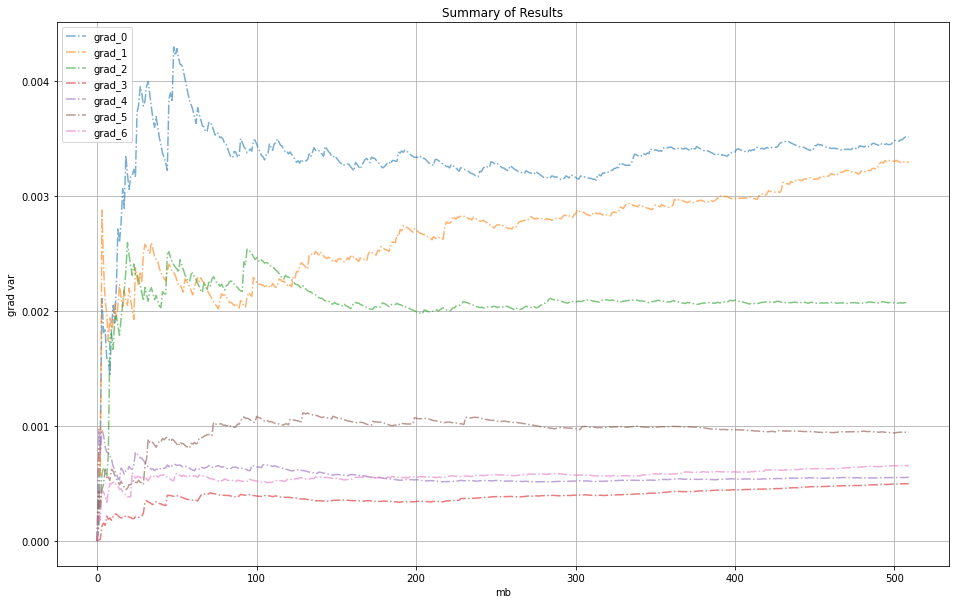

In [118]:
record_graph([record_SGD],'grad_var_mb')

In [32]:
# np.save("beta_SGD.npy", beta_SGD)

In [36]:
# import pickle

# with open('record_SGD.pkl', 'wb') as f:
#     pickle.dump(record_SGD, f, pickle.HIGHEST_PROTOCOL)

### Experiment with MNIST

In [123]:
mnist_train_images.shape

(60000, 28, 28)

In [146]:
n_features = 28*28
n_classes = 10
np.random.seed(4212)

beta_init = np.random.normal(0,(1/(n_features*n_classes)), size=[n_classes, n_features])

In [147]:
beta_init.shape

(10, 784)

In [148]:
train_data, test_data, train_label, test_label = mnist_train_images.reshape(-1,28*28), mnist_test_images.reshape(-1,28*28), mnist_train_labels, mnist_test_labels

In [149]:
print(np.unique(train_label, return_counts=True))
print(np.unique(test_label, return_counts=True))
print(train_data.shape)
print(test_data.shape)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
      dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009],
      dtype=int64))
(60000, 784)
(10000, 784)


In [152]:
beta = np.copy(beta_init)

beta_SGD, record_SGD = train_SGD(train_data[:5000], train_label[:5000], test_data[:5000], test_label[:5000], beta_init, 0.00001, loss_LR_values_and_grad, verbose = 1, n_epoch=10, mb_size=100)

Epoch 0: 2.57 seconds, Loss: 0.76, Test Accuracy: 0.752
Epoch 1: 2.50 seconds, Loss: 0.38, Test Accuracy: 0.849
Epoch 2: 2.49 seconds, Loss: 0.33, Test Accuracy: 0.864
Epoch 3: 2.51 seconds, Loss: 0.30, Test Accuracy: 0.867
Epoch 4: 2.53 seconds, Loss: 0.28, Test Accuracy: 0.870
Epoch 5: 2.65 seconds, Loss: 0.27, Test Accuracy: 0.873
Epoch 6: 2.55 seconds, Loss: 0.26, Test Accuracy: 0.871
Epoch 7: 2.50 seconds, Loss: 0.25, Test Accuracy: 0.873
Epoch 8: 2.60 seconds, Loss: 0.24, Test Accuracy: 0.874
Epoch 9: 2.59 seconds, Loss: 0.23, Test Accuracy: 0.873


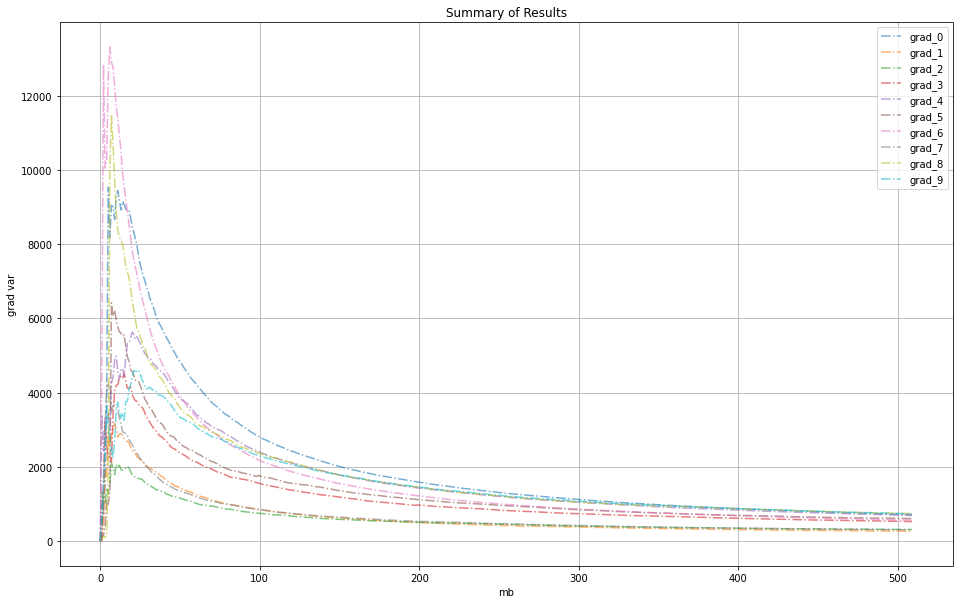

In [153]:
record_graph([record_SGD],'grad_var_mb')

### Experiment with Adult

In [154]:
adult_feature_train_norm.shape

(32561, 108)

In [157]:
n_features = 108
n_classes = 2
np.random.seed(4212)

beta_init = np.random.normal(0,(1/(n_features*n_classes)), size=[n_classes, n_features])

In [158]:
beta_init.shape

(2, 108)

In [204]:
train_data, test_data, train_label, test_label = adult_feature_train_norm, adult_feature_test_norm, adult_label_train_bi, adult_label_test_bi

In [205]:
print(np.unique(train_label, return_counts=True))
print(np.unique(test_label, return_counts=True))
print(train_data.shape)
print(test_data.shape)

(array([0, 1]), array([24720,  7841], dtype=int64))
(array([0, 1]), array([12435,  3846], dtype=int64))
(32561, 108)
(16281, 108)


In [220]:
beta = np.copy(beta_init)

beta_SGD, record_SGD = train_SGD(train_data[:10000], train_label[:10000], test_data[:10000], test_label[:10000], beta_init, 0.001, loss_LR_values_and_grad, verbose = 1, n_epoch=10, mb_size=100)

Epoch 0: 8.58 seconds, Loss: 0.67, Test Accuracy: 0.705
Epoch 1: 8.43 seconds, Loss: 0.62, Test Accuracy: 0.756
Epoch 2: 9.74 seconds, Loss: 0.59, Test Accuracy: 0.755
Epoch 3: 10.28 seconds, Loss: 0.56, Test Accuracy: 0.753
Epoch 4: 11.14 seconds, Loss: 0.54, Test Accuracy: 0.751
Epoch 5: 11.51 seconds, Loss: 0.52, Test Accuracy: 0.750
Epoch 6: 9.75 seconds, Loss: 0.51, Test Accuracy: 0.748
Epoch 7: 10.59 seconds, Loss: 0.50, Test Accuracy: 0.746
Epoch 8: 10.35 seconds, Loss: 0.49, Test Accuracy: 0.744
Epoch 9: 9.57 seconds, Loss: 0.48, Test Accuracy: 0.742


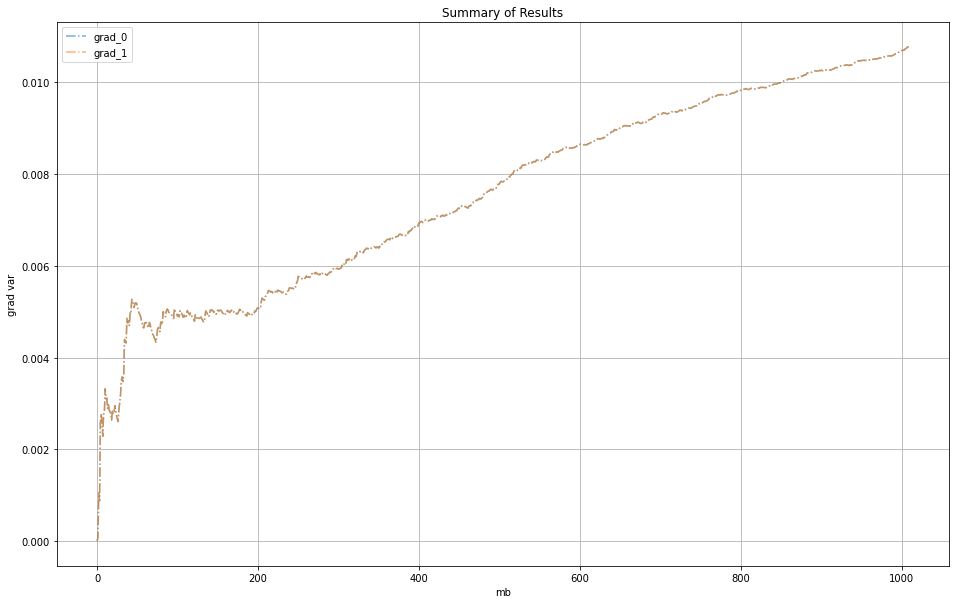

In [221]:
record_graph([record_SGD],key='grad_var_mb',alpha=0.6)